# Facebook Social Circles
Link: https://snap.stanford.edu/data/ego-Facebook.html

This dataset consists of 'circles' (or 'friends lists') from Facebook. Facebook data was collected from survey participants using this Facebook app.

The focus of this first analysis is to learn to *split* the data into a **training and test set**, with focus on **negative sampling** techniques.

In [11]:
# Imports
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Const
dataset = "data/facebook_combined.txt"
random.seed(42)

In [12]:
## Create Graph ##
G = nx.read_edgelist(dataset, nodetype=int)

print("Nodes:",len(list(G.nodes)))
print("Edges:",len(list(G.edges)))

Nodes: 4039
Edges: 88234


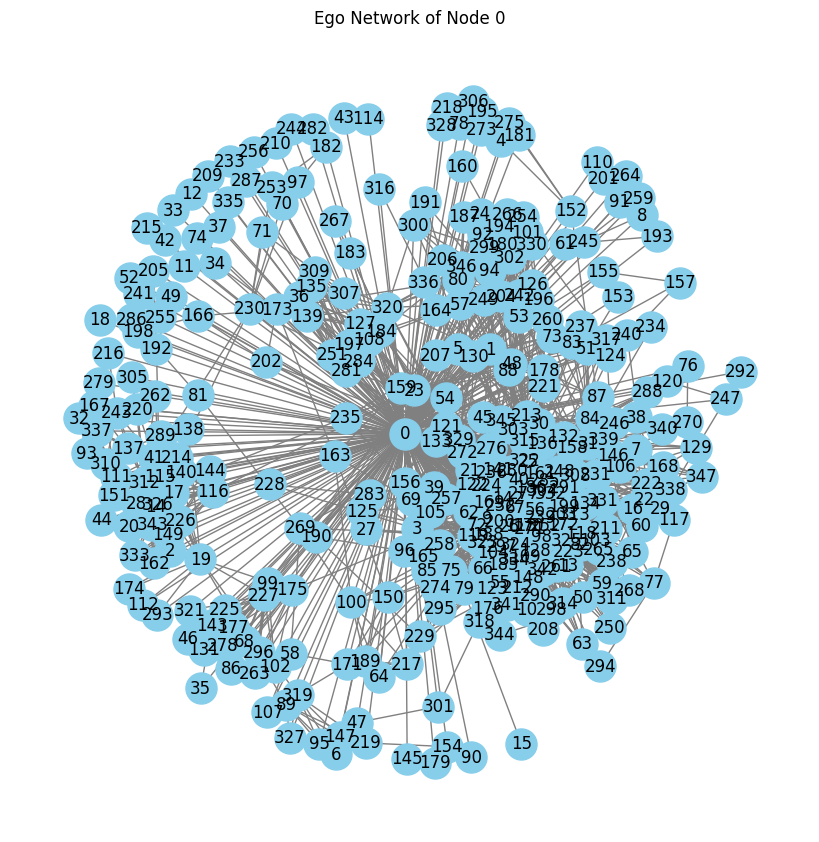

In [13]:
## Draw the graph ##
## The ego network allow to easily analyze and understand local network structure ##

ego = nx.ego_graph(G, 0) # Ego Network of node 0
pos = nx.spring_layout(ego, seed=42) # Spring layout for better visualization
plt.figure(figsize=(8, 8))
nx.draw(ego, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=500)
plt.title("Ego Network of Node 0")
plt.show()

In [14]:
## Define features ##

def common_neighbors(u, v, G):
    return len(list(nx.common_neighbors(G, u, v)))

def build_feature_dataset(pairs, G):
    return [[common_neighbors(u, v, G)] for u, v in pairs]

In [15]:
## Negative Sampling ##

# First method: Random Negative Sampling (O(negative_set_size))
## Note after execution: ~1m running time
def random_negative_sampling(positive_samples, num_nodes, negative_samples_ratio=1):
    positive_set = set(tuple(sorted(link)) for link in positive_samples) # Set for O(1) lookup

    negative_candidates = set()
    negative_set_size = len(positive_set) * negative_samples_ratio

    while len(negative_candidates) < negative_set_size: # O(n)
        u, v = random.sample(range(num_nodes), 2) # Should be O(1)
        pair = tuple(sorted((u, v)))

        if pair not in positive_set and pair not in negative_candidates:
            negative_candidates.add(pair)

    return negative_candidates

In [16]:
## Create train and test split ##
## 80% for training, 20% for testing ##

edges = list(G.edges())
random.shuffle(edges)
split_idx = int(0.8 * len(edges))

# Positive Edges
train_edges = edges[:split_idx]
test_edges = edges[split_idx:]

G_train = nx.Graph()
G_train.add_nodes_from(G.nodes())
G_train.add_edges_from(train_edges)

# Negative Edges
negative_edges = random_negative_sampling(edges, len(list(G.nodes)))
negative_edges = list(negative_edges)
random.shuffle(negative_edges)
neg_train_edges = negative_edges[:split_idx]
neg_test_edges = negative_edges[split_idx:]

In [17]:
# Combined Positive + Negative (Train)
X_train_pos = build_feature_dataset(train_edges, G_train)
X_train_neg = build_feature_dataset(neg_train_edges, G_train)
X_train = X_train_pos + X_train_neg
y_train = np.concatenate([np.ones(len(X_train_pos)), np.zeros(len(X_train_neg))])

# Combined Positive + Negative (Test)
X_test_pos = build_feature_dataset(test_edges, G_train)
X_test_neg = build_feature_dataset(neg_test_edges, G_train)
X_test = X_test_pos + X_test_neg
y_test = [1]*len(X_test_pos) + [0]*len(X_test_neg)

In [18]:
## Train on Random Forest ##

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [19]:
## Evaluate ##

y_pred = clf.predict_proba(X_test)[:,1] # Returns 2D with 0 and 1 class probability pairs
auc = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC: {auc:.4f}")

ROC-AUC: 0.9907


Lo score sembra troppo alto. Probabilmente i nodi scelti random come esempi negativi sono troppo semplici. Devo provare nuove euristiche di scelta dei nodi di classe negativa, tra cui alcuni che scelgano nodi difficili da distinguere da quelli positivi (con common neighbors saranno nodi con tanti nodi in comune ma non collegati tra loro)

In [20]:
# TODO try new negative sampling methods